# David Stanko
# Image Classification Notebook

## Introduction

The goal of this notebook is to train and test a neural network that performs image classification. The neural network will predict whether an image is an airplane, a bird, or an automobile.

## Data source

We will use the [CIFAR-10 dataset](https://keras.io/api/datasets/cifar10/) from Keras' built-in datasets. This is a dataset with 32 x 32 color images of 10 different objects. The objects are airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, or trucks. However, for this project, we will only train our neural network to classify the first three categories of images: airplanes, automobiles, and birds.

## Install and import libraries

In [26]:
!pip install keras-tuner

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the CIFAR-10 dataset

We will load all the training examples and all the testing examples.

In [29]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

## Data preprocessing

### Inspect the contents of the datasets

In [30]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In the entire dataset, there are 50,000 training examples and 10000 testing examples. They are all 32 x 32 images with 3 color channels.

Let's show some of the images and their labels.

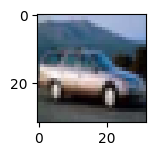

[1]


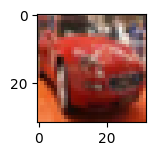

[1]


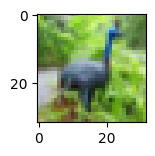

[2]


In [31]:
for i in range(4, 7):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(Y_train[i])

### Flatten the images from a 3D array to a 1D array

In [32]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(50000, 3072)

In [33]:
X_test = X_test.reshape(X_test.shape[0], -1)
X_test.shape

(10000, 3072)

Now each row is an image, and the columns of each row are the pixels of that image.

### Select only the birds, airplanes, and automobiles

Now we will only select the images that are birds, airplanes, and automobiles (with class labels 0, 1, and 2, respectively). This code finds the array indices where the training and testing data has labels 0, 1, and 2. Then we select the data at those indices.

In [34]:
Y_train = Y_train.reshape(1, -1)
Y_test = Y_test.reshape(1, -1)
selected_indices_train = np.where((Y_train == 0) | (Y_train == 1) | (Y_train == 2))
selected_indices_test = np.where((Y_test == 0) | (Y_test == 1) | (Y_test == 2))

Y_train = Y_train[selected_indices_train]
Y_test = Y_test[selected_indices_test]
X_train = X_train[selected_indices_train[1]]
X_test = X_test[selected_indices_test[1]]

print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

(3000, 3072)
(15000, 3072)
(3000,)
(15000,)


We will reshape Y_train and Y_test again to be compatible for training the neural network and making predictions with it.

In [35]:
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
num_classes = len(np.unique(Y_train))

### Normalize the data

We will normalize the data by dividing each pixel by 255.

In [36]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

## Build the neural network and conduct a parameter sweep

We will use `keras_tuner` to find the best hyperparameters of the neural network. Then, we will load the neural network with the best model architecture and test that neural network with the test dataset.

The `define_model function` defines the number of layers, the metric (we will use accuracy), the loss function, and the optimizer. We will use either the sigmoid or ReLU activation functions (determined by the parameter sweep) for all the layers except the output layer. But we will use softmax for the output layer because softmax converts the outputs of the layer to a probability distribution where all 3 outputs are between 0 and 1 and sum to 1.

In [37]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers
    model_layers += [layers.Dense(num_classes, activation='softmax')]
    model = keras.Sequential(model_layers)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

    return model

For the tuner, we need a function that takes hyperparameters and returns a model. That function is `build_model`. For the parameter sweep, we can choose between 512, and 3072 units per layer. (I chose 3072 since that is the number of pixels in each image). We can choose between 2, 3, 4, or 5 layers in the neural network. We can choose between a sigmoid and ReLU activation function. For the learning rate and the L2 regularization, we'll use logarithmically spaced values between 1^(-5) and 1^(-1).

In [38]:
def build_model(hp):
    units = hp.Choice("units", [512, 3072])
    activation = hp.Choice("activation", ["relu", "sigmoid"])
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 3, 4, 5])

    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

This code creates the tuner object. We will test the accuracy on the validation dataset, and we will test 8 model configurations at most.

In [39]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/models/cifar10_sweep_11",
)

Reloading Tuner from /content/drive/MyDrive/models/cifar10_sweep_11/untitled_project/tuner0.json


This code defines a callback function. The callback function will be called at the end of every epoch to check whether the accuracy is still increasing. We will start monitoring the validation loss after 4 epochs, and if it's not improving after 2 epochs, we will stop the training.

In [40]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

This code performs the parameter sweep. We will use 10 epochs. (Note that it will take a long time to run; it took 4 minutes for me on a GPU).


In [41]:
tuner.search(
    X_train_norm,
    Y_train,
    epochs=10,
    verbose=1,
    validation_data=(X_test_norm, Y_test),
    callbacks=callbacks
)

To see the results of the parameter sweep, we'll print out the 5 best models.

In [42]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/models/cifar10_sweep_11/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
units: 512
activation: sigmoid
lr: 0.0002920193478525102
l2: 0.00017109264361349003
num_layers: 4
Score: 0.6869243383407593

Trial 0 summary
Hyperparameters:
units: 3072
activation: relu
lr: 8.561545772838868e-05
l2: 5.031367553204709e-05
num_layers: 5
Score: 0.7498770952224731

Trial 4 summary
Hyperparameters:
units: 512
activation: relu
lr: 0.000155862916523137
l2: 0.06292023822783538
num_layers: 2
Score: 0.7981525659561157

Trial 5 summary
Hyperparameters:
units: 3072
activation: relu
lr: 0.027857427733600323
l2: 6.849324968662723e-05
num_layers: 5
Score: 0.8012748956680298

Trial 7 summary
Hyperparameters:
units: 512
activation: relu
lr: 0.04879508350820232
l2: 0.007559607779712685
num_layers: 4
Score: 1.0989466905593872


## Load the best model and use it to make predictions

The best model was number 1. So the best model architecture had 512 units per layer, a sigmoid activation function, 4 layers, a learning rate of about 0.00029, and an L2 regularization coefficient of about 0.00017.

We will load model 1 and use it to make predictions with the test dataset.


In [43]:
import json
from sklearn.metrics import confusion_matrix

trial_num = "1"
with open(f"/content/drive/MyDrive/models/cifar10_sweep_11/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation=hp["activation"], lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/models/cifar10_sweep_11/untitled_project/trial_{trial_num}/checkpoint")

In the following code, we will perform the prediction and print the confusion matrix and the accuracy. `model.predict()` returns the probability for each class that the image belongs to that class. So, since we want to get the index of the class, we'll use `np.argmax()`.

In [44]:
probabilities = model.predict(X_test_norm)
y_pred = np.argmax(probabilities, axis=1)
Y_test = Y_test.reshape(-1,)
cm = confusion_matrix(Y_test, y_pred)
print(cm)
accuracy = (y_pred.reshape((1, -1)) == Y_test.reshape((1, -1))).sum() / len(Y_test) * 100
print(accuracy)

94/94 [==============================] - 3s 5ms/step
[[783  69 148]
 [134 736 130]
 [159  59 782]]
76.7


The accuracy is 76.7%. That's very good compared to the accuracy we would get by just guessing, which is about 33%.

In the code cell below, we will use Pandas to label the confusion matrix with the class labels, so we can see which actual and predicted classes the matrix entries belong to.

In [45]:
classes = ['airplane', 'automobile', 'bird']
cm_df = pd.DataFrame(cm, columns=classes, index = classes, dtype=int)
cm_df

,airplane,automobile,bird
airplane,783,69,148
automobile,134,736,130
bird,159,59,782


## Looking more closely at which images were misclassified

First we will calculate the percentages of birds, planes, and automobiles that were classified correctly, respectively.

In [46]:
cm_df.loc['bird', 'bird']/sum(cm_df.loc['bird']) * 100

78.2

In [47]:
cm_df.loc['airplane', 'airplane']/sum(cm_df.loc['airplane']) * 100

78.3

In [48]:
cm_df.loc['automobile', 'automobile']/sum(cm_df.loc['automobile']) * 100

73.6

The accuracies for each individual class are very close to each other. So, the neural network can classify birds, planes, and automobiles with high accuracy. However, the accuracy for automobiles is slightly lower than the others (73.6%).

Let's look at the misclassfied automobiles. Additionally, birds were often predicted as planes, and planes were often predicted as birds. Those two matrix entries have the two highest numbers of misclassified examples. So, we will also look at those misclassified images and compare them to the automobile ones.

The following code cell finds the testing examples that are known to be automobiles but were predicted to be birds or planes, respectively.

In [49]:
automobiles_as_airplanes = X_test[np.where((Y_test == 1) & (y_pred == 0))].reshape((-1, 32, 32, 3)) # automobiles predicted as airplanes
automobiles_as_birds = X_test[np.where((Y_test == 1) & (y_pred == 2))].reshape((-1, 32, 32, 3)) # automobiles predicted as airplanes

The following code cell finds the testing examples that are known to be planes but predicted as birds, and the ones that are known to be birds but predicted as planes.

In [50]:
airplanes_as_birds = X_test[np.where((Y_test == 0) & (y_pred == 2))].reshape((-1, 32, 32, 3)) # airplanes predicted as birds
birds_as_airplanes = X_test[np.where((Y_test == 2) & (y_pred == 0))].reshape((-1, 32, 32, 3)) # birds predicted as planes

The following code shows some of the misclassified images we found above.

Image number 1


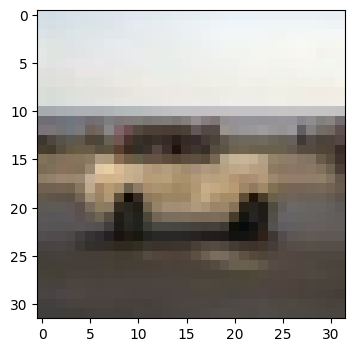

Image number 2


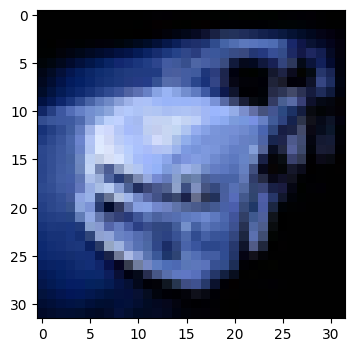

Image number 3


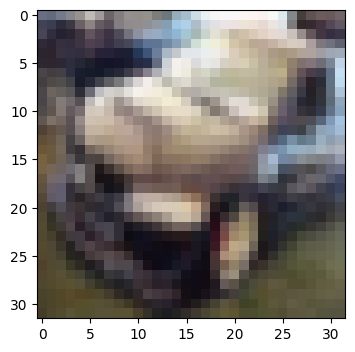

Image number 4


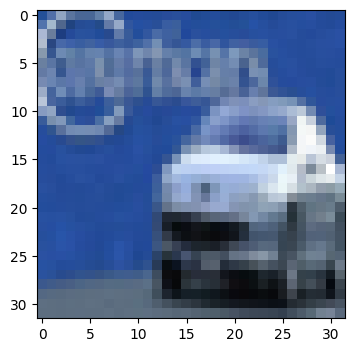

Image number 5


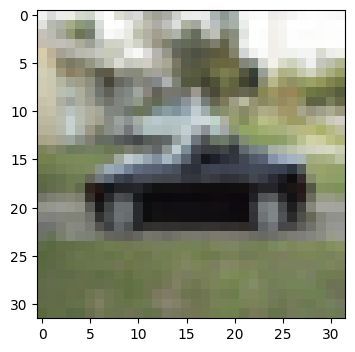

Image number 6


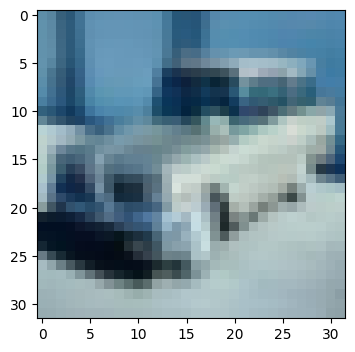

Image number 7


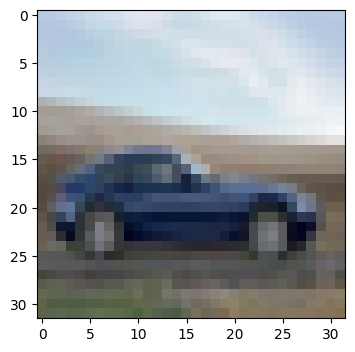

Image number 8


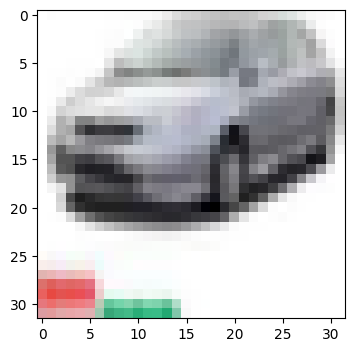

Image number 9


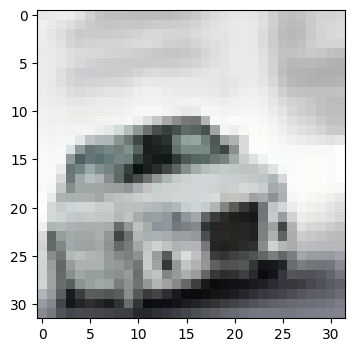

Image number 10


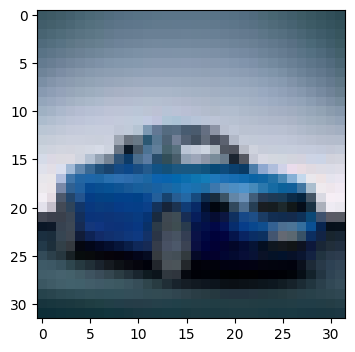

In [51]:
plt.rcParams["figure.figsize"] = (4, 4) # set the figure size
for i in range(10):
  print(f"Image number {i+1}")
  plt.imshow(automobiles_as_airplanes[i], cmap=plt.get_cmap('gray'))
  plt.show()

Image number 1


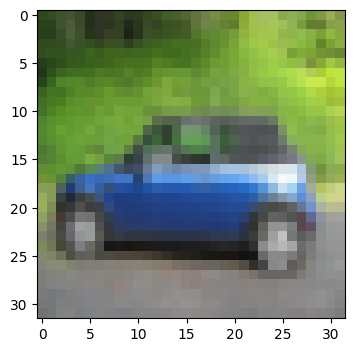

Image number 2


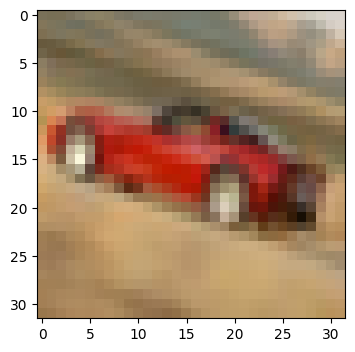

Image number 3


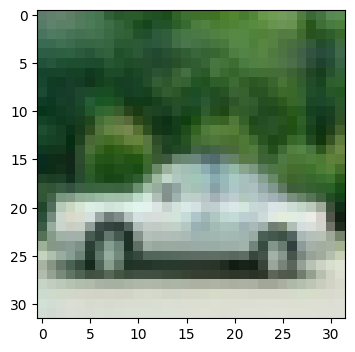

Image number 4


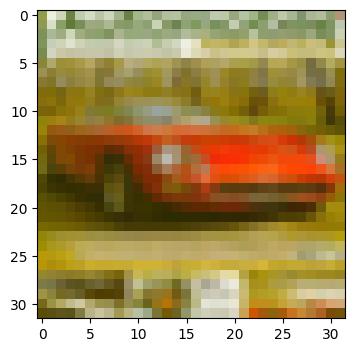

Image number 5


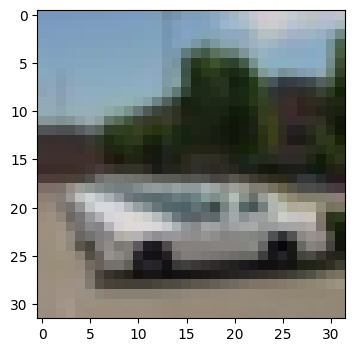

Image number 6


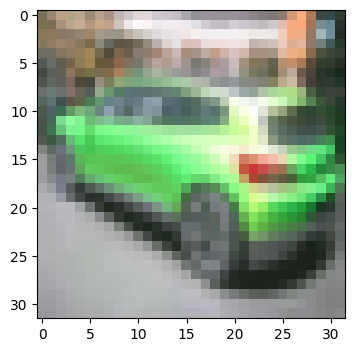

Image number 7


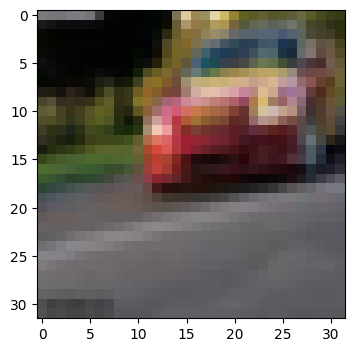

Image number 8


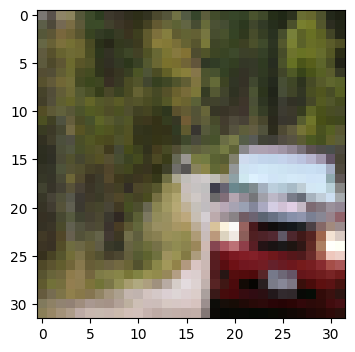

Image number 9


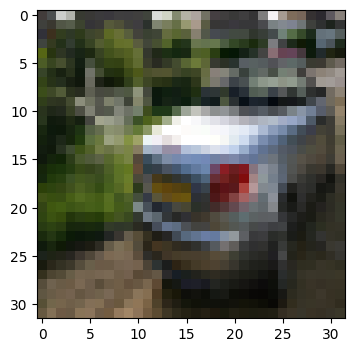

Image number 10


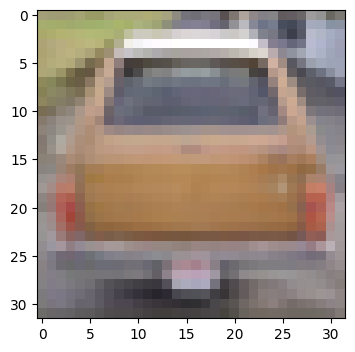

In [52]:
for i in range(10):
  print(f"Image number {i+1}")
  plt.imshow(automobiles_as_birds[i], cmap=plt.get_cmap('gray'))
  plt.show()

To a human viewer, all of the misclassified automobile images are clearly automobiles, even though the images are blurry.

Image number 1


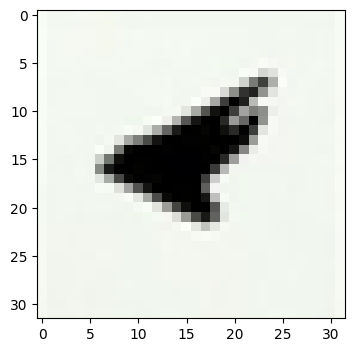

Image number 2


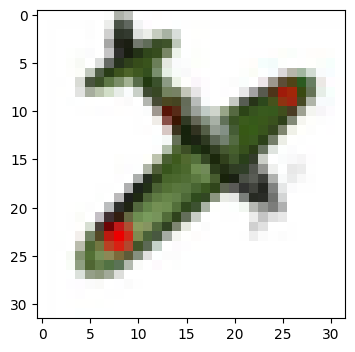

Image number 3


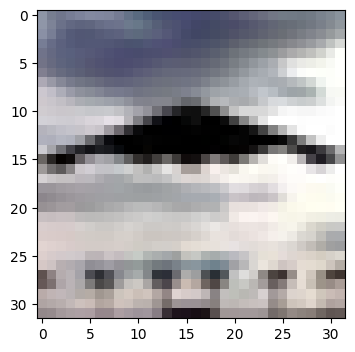

Image number 4


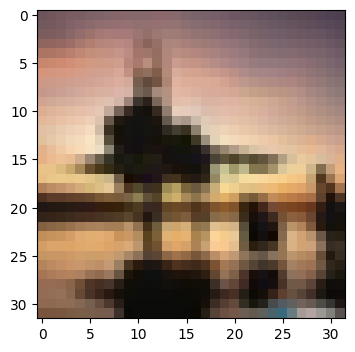

Image number 5


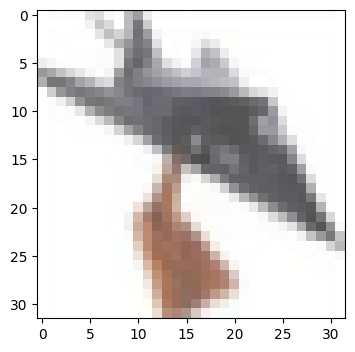

Image number 6


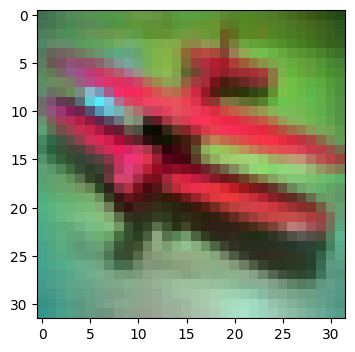

Image number 7


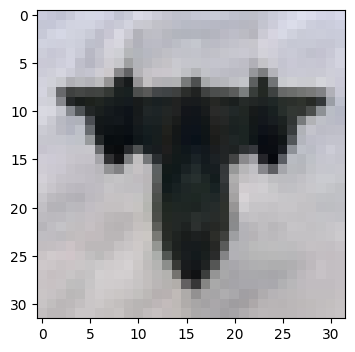

Image number 8


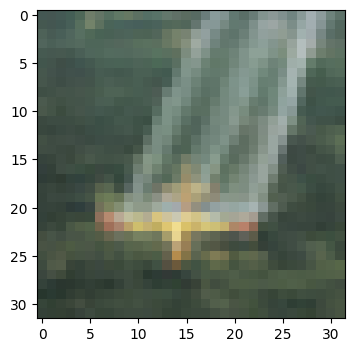

Image number 9


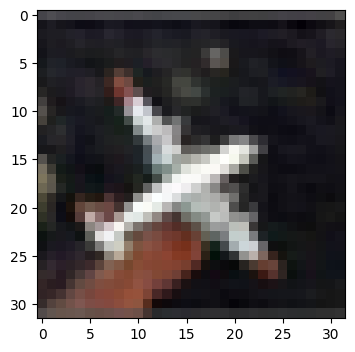

Image number 10


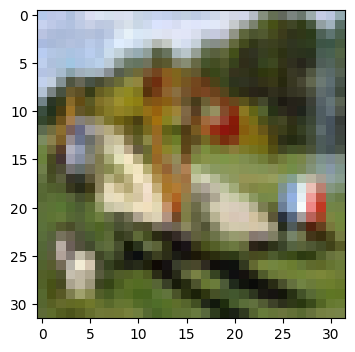

Image number 11


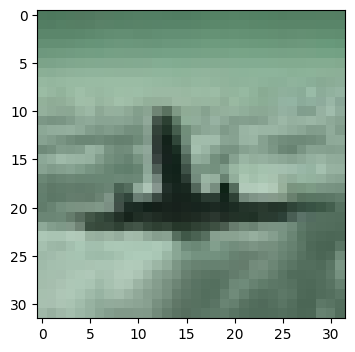

Image number 12


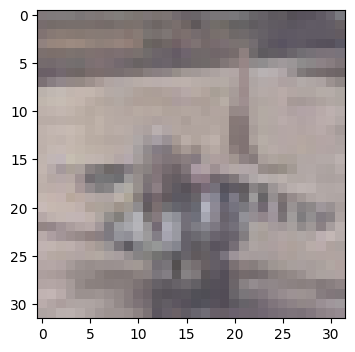

Image number 13


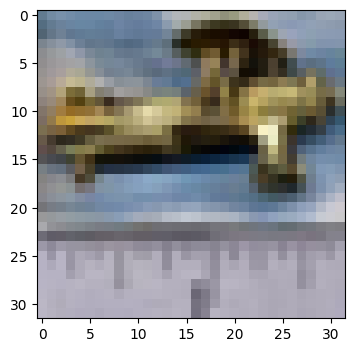

Image number 14


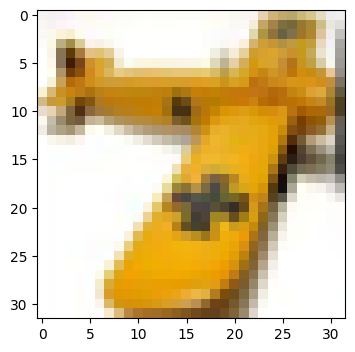

Image number 15


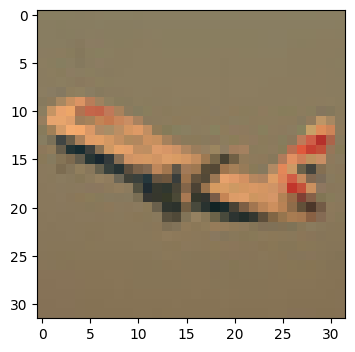

In [53]:
for i in range(15):
  print(f"Image number {i+1}")
  plt.imshow(airplanes_as_birds[i], cmap=plt.get_cmap('gray'))
  plt.show()

Looking at the misclassified airplanes, images 1, 3, 4, 10, and 12 look a lot like birds and could easily be interpreted as birds to a human viewer. It's not very clear that they are planes to a human. So, the fact that the neural network classifies these images incorrectly doesn't necessarily mean the neural network is inaccurate.

Image number 1


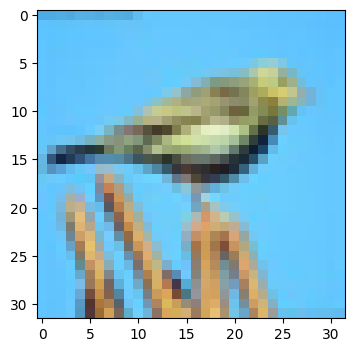

Image number 2


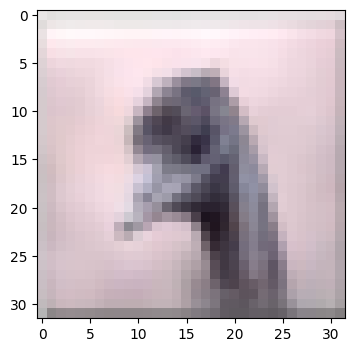

Image number 3


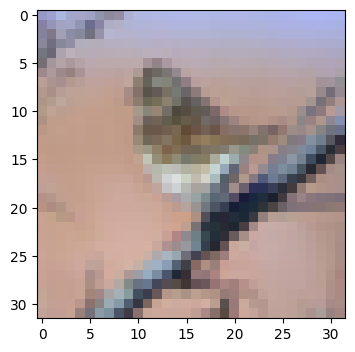

Image number 4


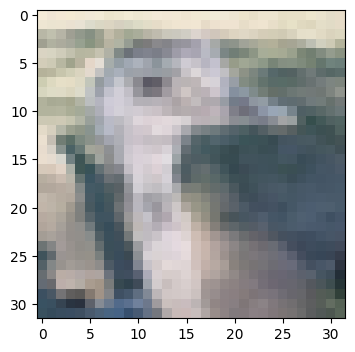

Image number 5


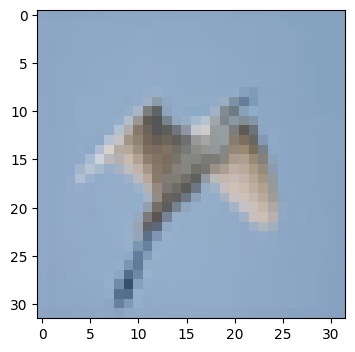

Image number 6


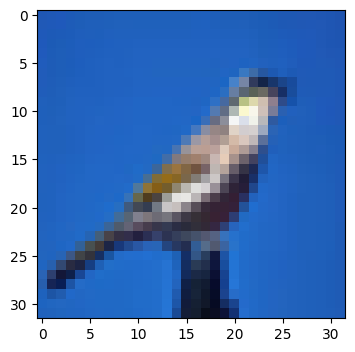

Image number 7


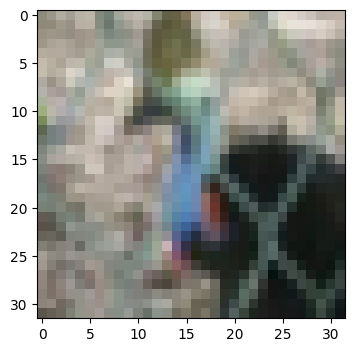

Image number 8


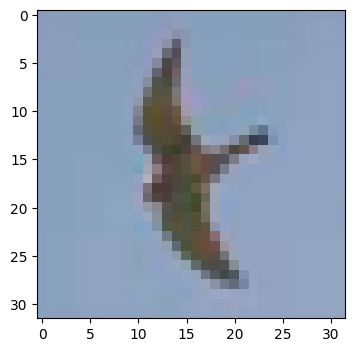

Image number 9


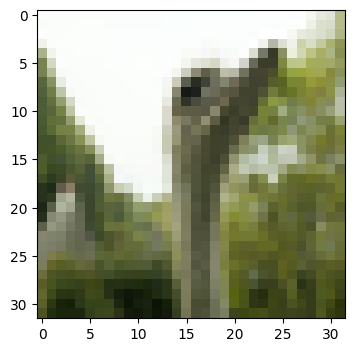

Image number 10


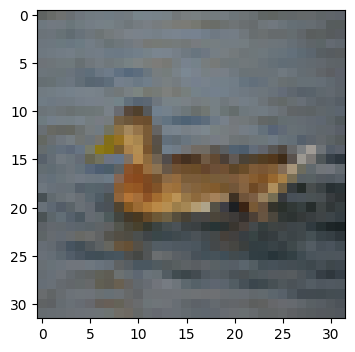

Image number 11


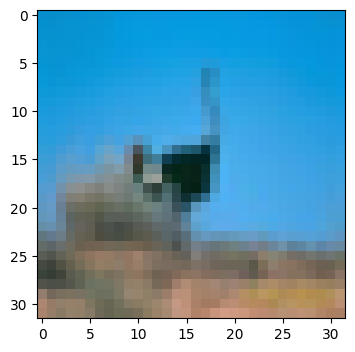

Image number 12


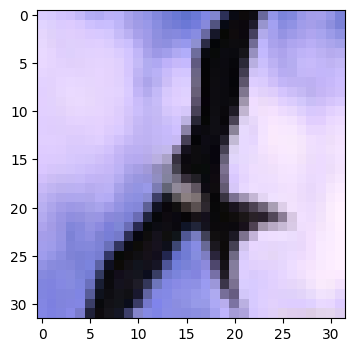

Image number 13


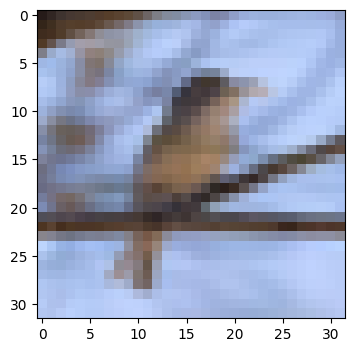

Image number 14


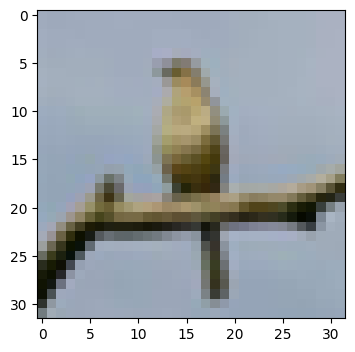

Image number 15


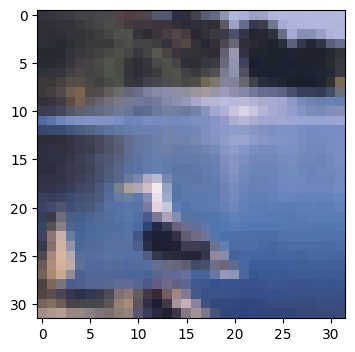

Image number 16


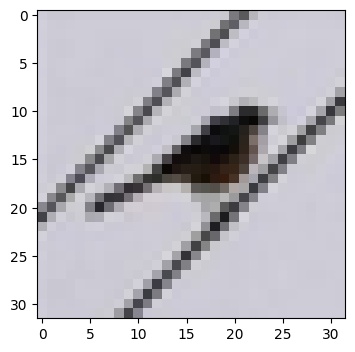

Image number 17


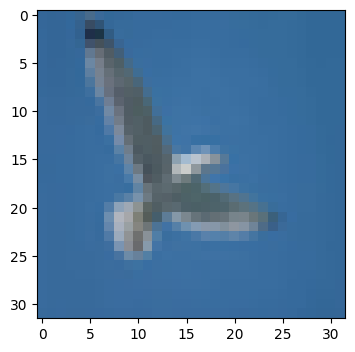

Image number 18


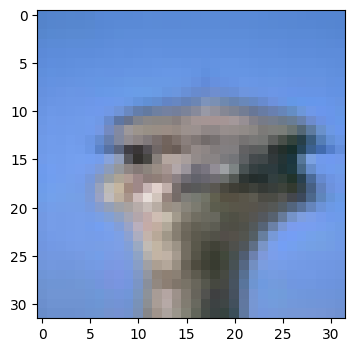

Image number 19


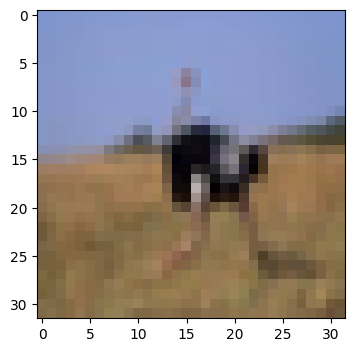

Image number 20


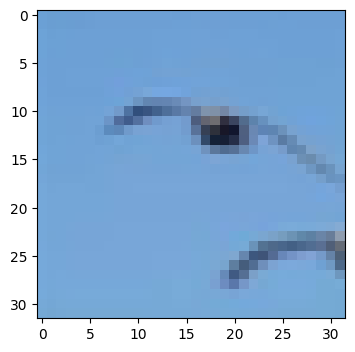

In [54]:
for i in range(20):
  print(f"Image number {i+1}")
  plt.imshow(birds_as_airplanes[i], cmap=plt.get_cmap('gray'))
  plt.show()

Most of the misclassified bird images look like birds to a human, even though they are blurry. The exceptions are images 11 and 15, which are so blurry that a human who doesn't know these are bird images may not be able to find the bird. But that's usually not the case. That tells us that our neural network often misclassifies birds as planes when a human would not.

## Conclusion

The neural network had a high accuracy, 76.7%. This is much more accurate than randomly guessing: since there are 3 classes, randomly guessing would give an accuracy of about 33.3%. In terms of the percentage of correct predictions for each class, the neural network was slightly worse at classifying automobiles than birds or planes. Looking at those misclassified automobile images, they clearly looked like automobiles to a human, so the problem is with the neural network, not that the images themselves are unclear.

Additionally, birds were often misclassified as planes, and vice versa. Looking at the misclassified plane images, some of them could be interpreted as birds by a human, so I concluded that the problem is with the image quality of the airplanes in the dataset. For the misclassified birds, most of those images clearly looked like birds to a human, so the problem was with the neural network.

Despite these issues, the percentage of correct predictions for each class was almost the same: 78.3% for planes, 78.2% for birds, and 73.6% for automobiles. So, the neural network is almost equally accurate for all categories of images. Furthermore, the overall accuracy is very high for only 10 epochs of training. Additionally, there was only a small number of planes misclassified as cars, and a small number of birds misclassified as cars. I only trained the neural network for 10 epochs to make my code run faster, but if I could train it for hundreds of epochs, the accuracy would be much higher. For future work, another method to improve the accuracy would be to use image processing techniques to make the images less blurry.